<a href="https://colab.research.google.com/github/neverix/GPU-Puzzles/blob/main/Triton_puzzlers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

trying to add Triton support

warning: will contain spoilers

# GPU Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp)

![](https://github.com/srush/GPU-Puzzles/raw/main/cuda.png)

GPU architectures are critical to machine learning, and seem to be
becoming even more important every day. However, you can be an expert
in machine learning without ever touching GPU code. It is hard to gain
intuition working through abstractions.

This notebook is an attempt to teach beginner GPU programming in a
completely interactive fashion. Instead of providing text with
concepts, it throws you right into coding and building GPU
kernels. The exercises use NUMBA which directly maps Python
code to CUDA kernels. It looks like Python but is basically
identical to writing low-level CUDA code.
In a few hours, I think you can go from basics to
understanding the real algorithms that power 99% of deep learning
today. If you do want to read the manual, it is here:

[NUMBA CUDA Guide](https://numba.readthedocs.io/en/stable/cuda/index.html)

I recommend doing these in Colab, as it is easy to get started.  Be
sure to make your own copy, turn on GPU mode in the settings (`Runtime / Change runtime type`, then set `Hardware accelerator` to `GPU`), and
then get to coding.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/GPU-Puzzles/blob/main/GPU_puzzlers.ipynb)

(If you are into this style of puzzle, also check out my [Tensor
Puzzles](https://github.com/srush/Tensor-Puzzles) for PyTorch.)

In [1]:
!pip install -qqq git+https://github.com/chalk-diagrams/planar git+https://github.com/danoneata/chalk@srush-patch-1

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [2]:
!pip install triton

In [3]:
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!export CUDA_LAUNCH_BLOCKING=1
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link



In [4]:
%load_ext autoreload
%autoreload 2
# !wget -q https://github.com/srush/GPU-Puzzles/raw/main/robot.png https://github.com/neverix/GPU-Puzzles/raw/main/lib.py
!wget -q https://github.com/srush/GPU-Puzzles/raw/main/robot.png https://github.com/srush/GPU-Puzzles/raw/main/lib.py

In [ ]:
#@title lib
%%file lib.py
from dataclasses import dataclass
import numpy as np
from chalk import *
from colour import Color
import chalk
from dataclasses import dataclass
from typing import List, Any
from collections import Counter
from numba import cuda
import numba
import random

@dataclass
class ScalarHistory:
    last_fn: str
    inputs: list

    def __radd__(self, b):
        return self + b

    def __add__(self, b):
        if isinstance(b, (float, int)):
            return self
        if isinstance(b, Scalar):
            return ScalarHistory(self.last_fn, self.inputs + [b])

        return ScalarHistory(self.last_fn, self.inputs + b.inputs)

class Scalar:
    def __init__(self, location):
        self.location = location

    def __mul__(self, b):
        if isinstance(b, (float, int)):
            return ScalarHistory("id", [self])
        return ScalarHistory("*", [self, b])


    def __radd__(self, b):
        return self + b

    def __add__(self, b):
        if isinstance(b, (float, int)):
            return ScalarHistory("id", [self])
        return ScalarHistory("+", [self, b])

    def __iadd__(self, other):
        assert False, "Instead of `out[] +=` use a local variable `acc + =`"

class Table:
    def __init__(self, name, array):
        self.name = name
        self.incoming = []
        self.array = array

        self.size = array.shape

    def __getitem__(self, index):
        self.array[index]
        if isinstance(index, int):
            index = (index,)
        assert len(index) == len(self.size), "Wrong number of indices"
        if index[0] >= self.size[0]:
            assert False, "bad size"

        return Scalar((self.name,) + index)

    def __setitem__(self, index, val):
        self.array[index]
        if isinstance(index, int):
            index = (index,)
        assert len(index) == len(self.size), "Wrong number of indices"
        if index[0] >= self.size[0]:
            assert False, "bad size"
        if isinstance(val, Scalar):
            val = ScalarHistory("id", [val])
        if isinstance(val, float):
            return
        self.incoming.append((index, val))

@dataclass(frozen=True, eq=True)
class Coord:
    x: int
    y: int

    def enumerate(self):
        k = 0
        for i in range(self.y):
            for j in range(self.x):
                yield k, Coord(j, i)
                k += 1

    # 💀
    def tuple(self):
        return (self.x, self.y)


class RefList:
    def __init__(self):
        self.refs = []

    def __getitem__(self, index):
        return self.refs[-1][index]

    def __setitem__(self, index, val):
        self.refs[-1][index] = val


class TritonLanguage:
    caches: list

    def __init__(self, blockIdx, blockDim, threadIdx):
        self.blockIdx = blockIdx
        self.blockDim = blockDim
        self.threadIdx = threadIdx
        self.caches = []
        self.saved = []

    def program_id(self, idx):
        return self.blockIdx[idx]

    def syncthreads(self):
        for i, c in enumerate(self.caches):
            old_cache = c.refs[-1]
            # self_links = cache.self_links()
            # cache.clean()
            temp = old_cache.incoming
            old_cache.incoming = self.saved[i]
            self.saved[i] = temp
            cache = Table(old_cache.name + "'", old_cache.array)

            c.refs.append(cache)

    def finish(self):
        for i, c in enumerate(self.caches):
            old_cache = c.refs[-1]
            old_cache.incoming = self.saved[i]

    def rounds(self):
        if len(self.caches) > 0:
            return len(self.caches[0].refs)
        else:
            return 0


#li Some drawing constants.

black = Color("black")
white = Color("white")
im = image(
    "robot.png", "https://raw.githubusercontent.com/minitorch/diagrams/main/robot.png"
).scale_uniform_to_x(1)
colors = list(Color("red").range_to(Color("blue"), 10))

def table(name, r, c):
    if r == 0:
        return concat(
            [rectangle(1, 1).translate(0, j).named((name, j)) for j in range(c)]
        ).center_xy()
    return concat(
        [
            rectangle(1, 1).translate(i, j).named((name, i, j))
            for i in range(r)
            for j in range(c)
        ]
    ).center_xy()


def myconnect(diagram, loc, color, con, name1, name2):
    bb1 = diagram.get_subdiagram_envelope(name1)
    bb2 = diagram.get_subdiagram_envelope(name2)
    assert bb1 is not None, f"{name1}: You may be reading/writing from an un'synced array"
    assert bb2 is not None, f"{name2}: You may be reading/writing from an un'synced array"
    off = P2(loc[0] - 0.5, loc[1] - 0.5) * 0.85
    dia = empty()
    if con:
        dia += (
            arc_between(bb1.center - V2(0.5, 0), bb2.center + off, 0)
            .line_width(0.04)
            .line_color(color)
        )
    dia += place_at(
        [rectangle(0.95, 0.95).fill_opacity(0).line_color(color).line_width(0.15)],
        [bb1.center],
    )
    dia += place_at(
        [circle(0.1).line_width(0.04).fill_color(color)], [bb2.center + off]
    )
    return dia

def draw_table(tab):
    t = text(tab.name, 0.5).fill_color(black).line_width(0.0)
    if len(tab.size) == 1:
        tab = table(tab.name, 0, *tab.size)
    else:
        tab = table(tab.name, *tab.size)
    tab = tab.line_width(0.05)
    return tab.beside((t + vstrut(0.5)), -unit_y)


def draw_connect(tab, dia, loc2, color, con):
    return concat(
        [
            myconnect(dia, loc2, color, con, (tab.name,) + loc, inp.location)
            for (loc, val) in tab.incoming
            for inp in val.inputs
        ]
    )

def grid(mat, sep):
    return vcat([ hcat([y for y in x] , sep) for x in mat], sep )

def draw_base(_, a, c, out):
    inputs = vcat([draw_table(d) for d in a], 2.0).center_xy()
    shared_tables = [[draw_table(c2.refs[i]) for i in range(1, c.rounds())] for c2 in c.caches]
    shareds = grid(shared_tables, 1.0).center_xy()
    outputs = draw_table(out).center_xy()
    return hcat([inputs, shareds, outputs], 2.0)


def draw_coins(tpbx, tpby):
    return concat(
        [
            (circle(0.5).fill_color(colors[tt]).fill_opacity(0.7) + im).translate(
                pos.x * 1.1, pos.y * 1.1
            )
            for tt, pos in Coord(tpbx, tpby).enumerate()
        ]
    )


def label(dia, content):
    t = vstrut(0.5) / text(content, 0.5).fill_color(black).line_width(0) / vstrut(0.5)
    dia = dia.center_xy()
    return (dia + dia.juxtapose(t, -unit_y)).center_xy()



def draw_results(results, name, tpbx, tpby, sparse=False):
    full = empty()
    blocks = []
    locations = []
    base = draw_base(*results[Coord(0, 0)][Coord(0, 0)])
    for block, inner in results.items():
        dia = base
        for pos, (tt, a, c, out) in inner.items():
            loc = (
                pos.x / tpbx + (1 / (2 * tpbx)),
                (pos.y / tpby)
                + (1 / (2 * tpby)),
            )
            color = colors[tt]

            lines = True
            if sparse:
                lines = (pos.x == 0 and pos.y == 0) or (
                    pos.x == (tpbx - 1)
                    and pos.y == (tpby - 1)
                )
            all_tabs = (
                a + [c2.refs[i] for i in range(1, c.rounds()) for c2 in c.caches] + [out]
            )
            dia = dia + concat(
                draw_connect(t, dia, loc, color, lines) for t in all_tabs
            )
        height = dia.get_envelope().height

        # Label block and surround
        dia = hstrut(1) | (label(dia, f"Block {block.x} {block.y}")) | hstrut(1)
        dia = dia.center_xy().pad(1.2)
        env = dia.get_envelope()
        dia = dia + rectangle(env.width, env.height, 0.5).line_color(
            Color("grey")
        ).fill_opacity(0.0)


        blocks.append(dia.pad(1.1))
        locations.append(P2(block.x, block.y))

    # Grid blocks
    env = blocks[0].get_envelope()
    offset = V2(env.width, env.height)
    full = place_at(blocks, [offset * l for l in locations])

    coins = draw_coins(tpbx, tpby)

    full = (
        vstrut(1.5)
        / text(name, 1)
        / vstrut(1)
        / coins.center_xy()
        / vstrut(1)
        / full.center_xy()
    )
    full = full.pad(1.1).center_xy()
    env = full.get_envelope()
    set_svg_height(50 * env.height)


    chalk.core.set_svg_output_height(500)
    return rectangle(env.width, env.height).fill_color(white) + full


#

@dataclass
class TritonProblem:
    name: str
    fn: Any
    inputs: List[np.ndarray]
    out: np.ndarray
    args: Tuple[int] = ()
    blockspergrid: Coord = Coord(1, 1)
    spec: Any = None

    def run_triton(self):
        fn = self.fn
        fn = fn(numba.cuda)
        jitfn = numba.cuda.jit(fn)
        jitfn[self.blockspergrid.tuple(), self.threadsperblock.tuple()](
            self.out, *self.inputs, *self.args
        )
        return self.out

    def run_python(self):
        results = {}
        fn = self.fn
        for _, block in self.blockspergrid.enumerate():
            results[block] = {}
            for tt, pos in self.threadsperblock.enumerate():
                a = []
                args = ["a", "b", "c", "d"]
                for i, inp in enumerate(self.inputs):
                    a.append(Table(args[i], inp))
                out = Table("out", self.out)

                c = Cuda(block, self.threadsperblock, pos)
                fn(c)(out, *a, *self.args)
                c.finish()
                results[block][pos] =  (tt, a, c, out)
        return results

    def score(self, results):

        total = 0
        full = Counter()
        for pos, (tt, a, c, out) in results[Coord(0, 0)].items():
            total += 1
            count = Counter()
            for out, tab in [(False, c2.refs[i]) for i in range(1, c.rounds()) for c2 in c.caches] + [(True, out)]:
                for inc in tab.incoming:
                    if out:
                        count["out_writes"] += 1
                    else:
                        count["shared_writes"] += 1
                    for ins in inc[1].inputs:
                        if ins.location[0].startswith("S"):
                            count["shared_reads"] += 1
                        else:
                            count["in_reads"] += 1
            for k in count:
                if count[k] > full[k]:
                    full[k] = count[k]
        print(f"""# {self.name}

   Score (Max Per Thread):
   | {'Global Reads':>13} | {'Global Writes':>13} | {'Shared Reads' :>13} | {'Shared Writes' :>13} |
   | {full['in_reads']:>13} | {full['out_writes']:>13} | {full['shared_reads']:>13} | {full['shared_writes']:>13} |
""")

    def show(self, sparse=False):
        results = self.run_python()
        self.score(results)
        return draw_results(results, self.name,
                            self.threadsperblock.x, self.threadsperblock.y, sparse)

    def check(self):
        x = self.run_triton()
        y = self.spec(*self.inputs)
        try:
            np.testing.assert_allclose(x, y)
            print("Passed Tests!")
            from IPython.display import HTML
            # I assure you, this list of puppy gifs is vital to the testing
            pups = [
            "2m78jPG",
            "pn1e9TO",
            "MQCIwzT",
            "udLK6FS",
            "ZNem5o3",
            "DS2IZ6K",
            "aydRUz8",
            "MVUdQYK",
            "kLvno0p",
            "wScLiVz",
            "Z0TII8i",
            "F1SChho",
            "9hRi2jN",
            "lvzRF3W",
            "fqHxOGI",
            "1xeUYme",
            "6tVqKyM",
            "CCxZ6Wr",
            "lMW0OPQ",
            "wHVpHVG",
            "Wj2PGRl",
            "HlaTE8H",
            "k5jALH0",
            "3V37Hqr",
            "Eq2uMTA",
            "Vy9JShx",
            "g9I2ZmK",
            "Nu4RH7f",
            "sWp0Dqd",
            "bRKfspn",
            "qawCMl5",
            "2F6j2B4",
            "fiJxCVA",
            "pCAIlxD",
            "zJx2skh",
            "2Gdl1u7",
            "aJJAY4c",
            "ros6RLC",
            "DKLBJh7",
            "eyxH0Wc",
            "rJEkEw4"]
            return HTML("""
            <video alt="test" controls autoplay=1>
                <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
            </video>
            """%(random.sample(pups, 1)[0]))

        except AssertionError:
            print("Failed Tests.")
            print("Yours:", x)
            print("Spec :", y)

In [5]:
import numba
import numpy as np
import warnings
from lib import CudaProblem, Coord

In [6]:
warnings.filterwarnings(
    action="ignore", category=numba.NumbaPerformanceWarning, module="numba"
)

## Puzzle 1: Map

Implement a "kernel" (GPU function) that adds 10 to each position of vector `a`
and stores it in vector `out`.  You have 1 thread per position.

**Warning** This code looks like Python but it is really CUDA! You cannot use
standard python tools like list comprehensions or ask for Numpy properties
like shape or size (if you need the size, it is given as an argument).
The puzzles only require doing simple operations, basically
+, *, simple array indexing, for loops, and if statements.
You are allowed to use local variables.
If you get an
error it is probably because you did something fancy :).

*Tip: Think of the function `call` as being run 1 time for each thread.
The only difference is that `cuda.threadIdx.x` changes each time.*

# Map
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



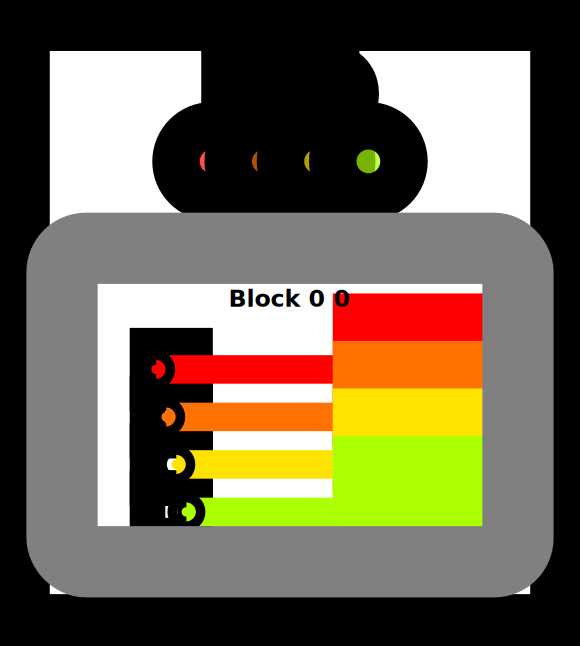

In [7]:
def map_spec(a):
    return a + 10


def map_tl(out, a, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    a_vals = tl.load(a + idx)
    tl.store(out + idx, a_vals + 10)


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Map", map_test, [a], out, threadsperblock=Coord(SIZE, 1), spec=map_spec
)
problem.show()

In [8]:
problem

CudaProblem(name='Map', fn=<function map_test at 0x7b5c634089d0>, inputs=[array([0, 1, 2, 3])], out=array([0., 0., 0., 0.]), args=(), blockspergrid=Coord(x=1, y=1), threadsperblock=Coord(x=4, y=1), spec=<function map_spec at 0x7b5c63408820>)

In [9]:
from inspect import getsource
import triton.language as tl
import triton
import torch


@triton.jit
def map_tl(out, a, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    a_vals = tl.load(a + idx)
    tl.store(out + idx, a_vals + 10)

def to_triton(arg):
    if isinstance(arg, np.ndarray):
        arg = torch.from_numpy(arg)
    if isinstance(arg, torch.Tensor):
        arg = arg.cuda()
    return arg

inputs = tuple(map(to_triton, problem.inputs)) + tuple(problem.args)
blocks, threads = problem.blockspergrid, problem.threadsperblock
out = to_triton(problem.out)
grid = blocks.x, blocks.y
map_tl[grid](out, *inputs, threads.x)
ptx = list(map_tl.cache[0].values())[0].asm["ptx"]
loads, stores = 0, 0
for line in ptx.split("\n"):
    loads += int("ld.global." in line)
    stores += int("st.global." in line)
print("Loads:", loads, "Stores:", stores)
x = out.detach().cpu().numpy()
y = problem.spec(*problem.inputs)
print("Triton vs CPU difference:", np.abs(x - y).sum())

Loads: 1 Stores: 1
Triton vs CPU difference: 0.0


In [32]:
pip install pymlir

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for pymlir: filename=pymlir-0.4-py3-none-any.whl size=34339 sha256=0c8ee24bdd45ddddaa4ff69ed76db2a1f07d2e8aea056a869713e705a4bdcd9f
  Stored in directory: /root/.cache/pip/wheels/76/ac/6e/a244d05ffec0041e6982469cbc2c21dae34c2287dd7c6bdd10
Successfully built pymlir


In [38]:
import mlir
parsed = mlir.parse_string(vars(next(iter(map_tl.cache[0].values())))["asm"]["ttir"],
                           dialects=[])

UnexpectedCharacters: ignored

In [7]:
problem.check()

Passed Tests!


## Puzzle 2 - Zip

Implement a kernel that adds together each position of `a` and `b` and stores it in `out`.
You have 1 thread per position.

In [14]:
og_show = CudaProblem.show
CudaProblem.show = lambda self, *args, **kwargs: print(self.args) # or og_show(self, *args, **kwargs)

In [17]:
def zip_spec(a, b):
    return a + b


def zip_test(cuda):
    def call(out, a, b) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 1 lines)
        out[local_i] = a[local_i] + b[local_i]
    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Zip", zip_test, [a, b], out, threadsperblock=Coord(SIZE, 1), spec=zip_spec
)
problem.show()

()


In [ ]:
problem.check()

Passed Tests!


## Puzzle 3 - Guards

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have more threads than positions.

In [18]:
def map_guard_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 2 lines)
        if local_i < size:
            out[local_i] = a[local_i] + 10
    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Guard",
    map_guard_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(8, 1),
    spec=map_spec,
)
problem.show()

[4]


In [ ]:
problem.check()

Passed Tests!


## Puzzle 4 - Map 2D

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
Input `a` is 2D and square. You have more threads than positions.

# Map 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



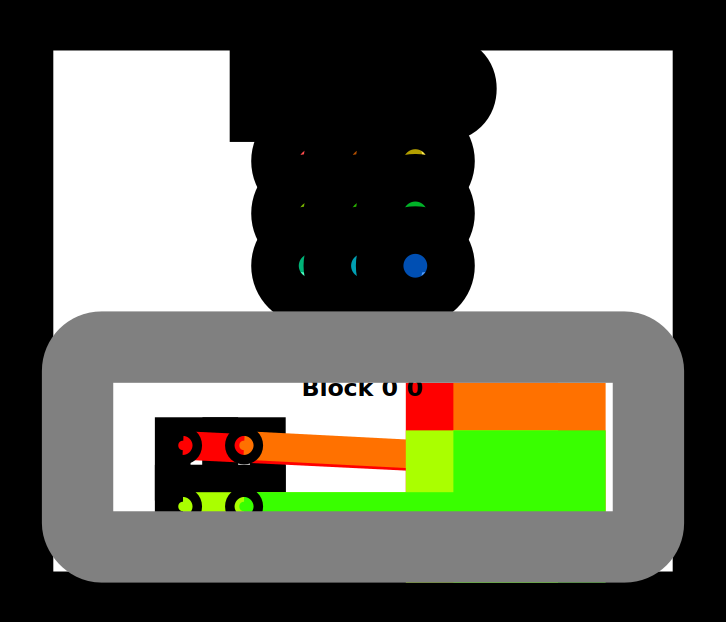

In [ ]:
def map_2D_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 2 lines)
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, local_j] + 10
    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
problem = CudaProblem(
    "Map 2D", map_2D_test, [a], out, [SIZE], threadsperblock=Coord(3, 3), spec=map_spec
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 5 - Broadcast

Implement a kernel that adds `a` and `b` and stores it in `out`.
Inputs `a` and `b` are vectors. You have more threads than positions.

# Broadcast
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 



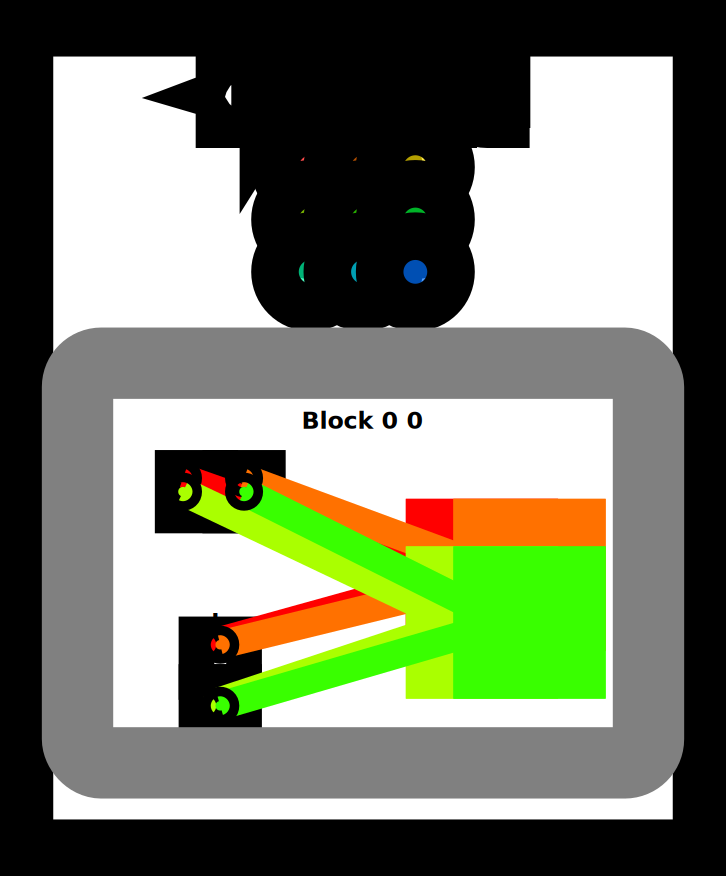

In [ ]:
def broadcast_test(cuda):
    def call(out, a, b, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 2 lines)
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, 0] + b[0, local_j]
    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE).reshape(SIZE, 1)
b = np.arange(SIZE).reshape(1, SIZE)
problem = CudaProblem(
    "Broadcast",
    broadcast_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=zip_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 6 - Blocks

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

*Tip: A block is a group of threads. The number of threads per block is limited, but we can
have many different blocks. Variable `cuda.blockIdx` tells us what block we are in.*

# Blocks
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



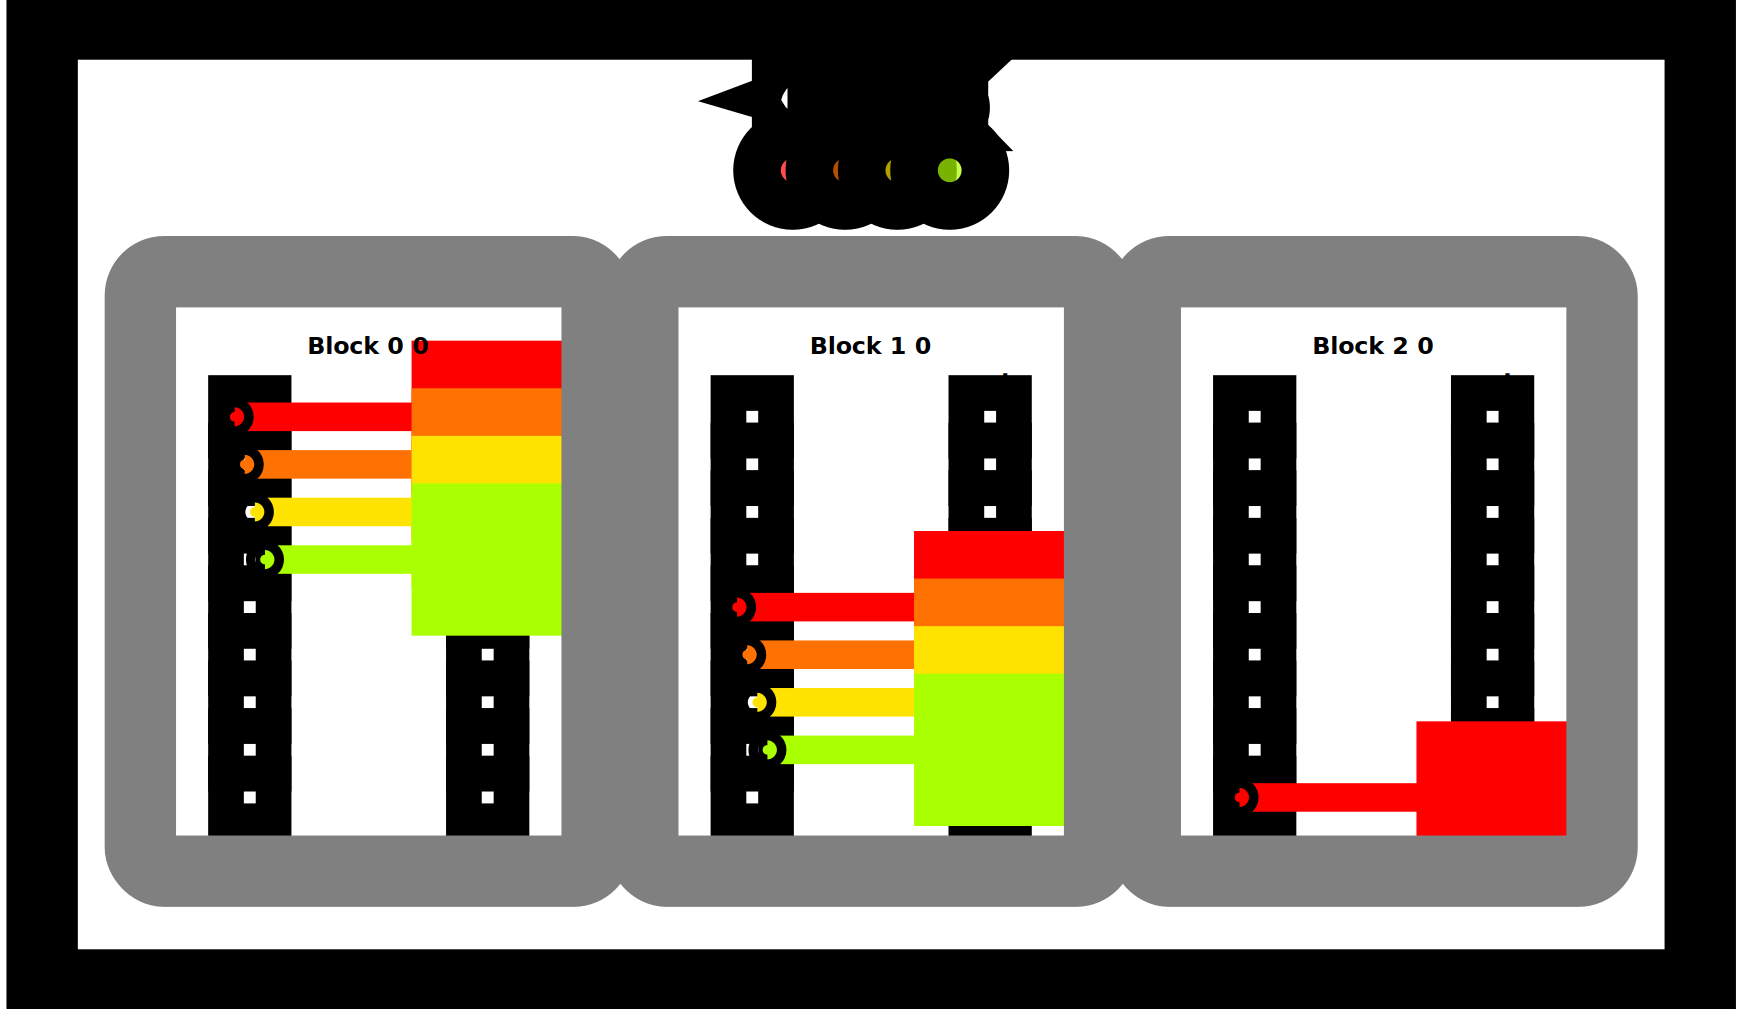

In [ ]:
def map_block_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        # FILL ME IN (roughly 2 lines)
        if i < size:
            out[i] = a[i] + 10
    return call


SIZE = 9
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Blocks",
    map_block_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(4, 1),
    blockspergrid=Coord(3, 1),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 7 - Blocks 2D

Implement the same kernel in 2D.  You have fewer threads per block
than the size of `a` in both directions.

# Blocks 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



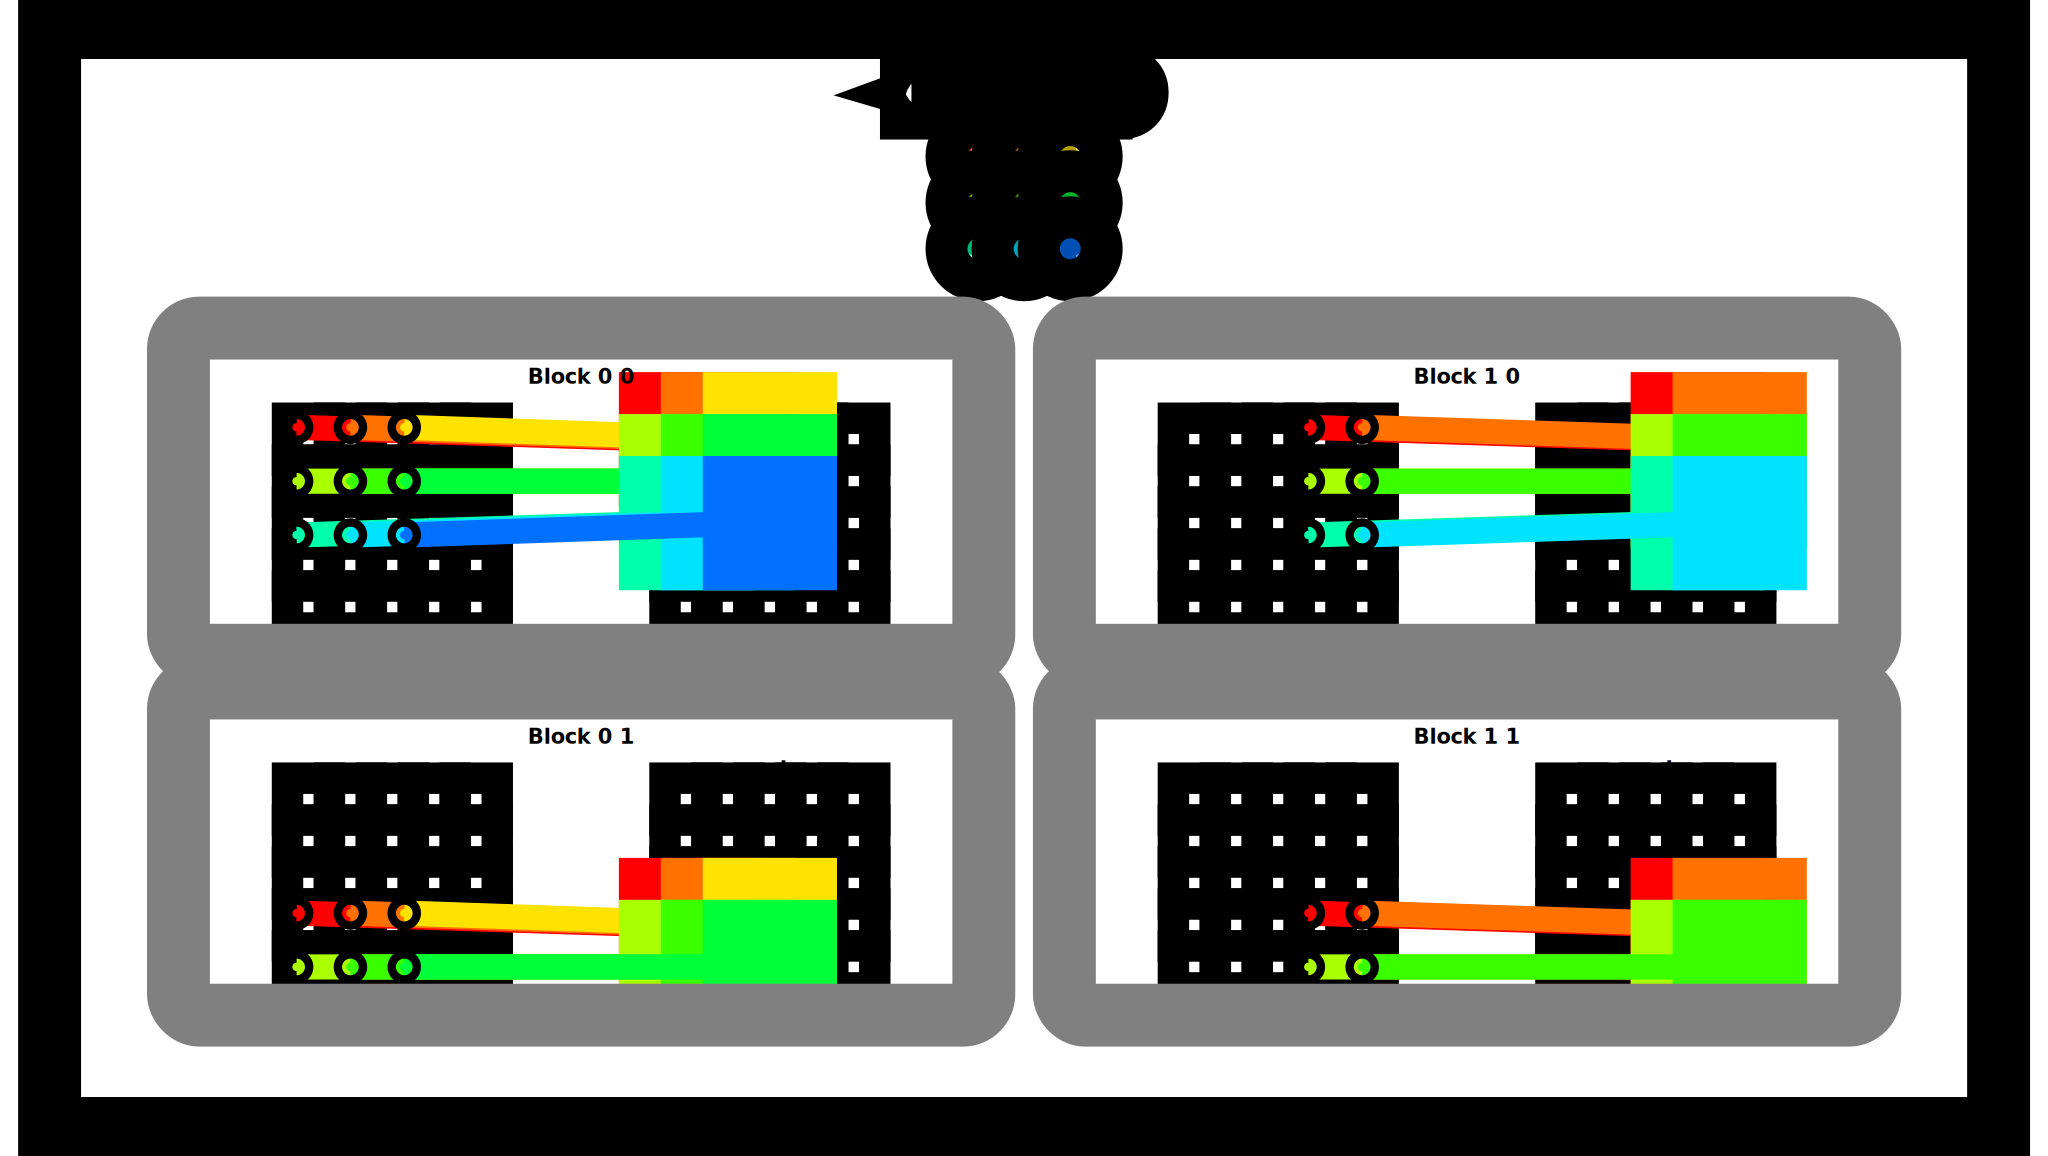

In [ ]:
def map_block2D_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        # FILL ME IN (roughly 4 lines)
        j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        if i < size and j < size:
            out[i, j] = a[i, j] + 10
    return call


SIZE = 5
out = np.zeros((SIZE, SIZE))
a = np.ones((SIZE, SIZE))

problem = CudaProblem(
    "Blocks 2D",
    map_block2D_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    blockspergrid=Coord(2, 2),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 8 - Shared

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

**Warning**: Each block can only have a *constant* amount of shared
 memory that threads in that block can read and write to. This needs
 to be a literal python constant not a variable. After writing to
 shared memory you need to call `cuda.syncthreads` to ensure that
 threads do not cross.

(This example does not really need shared memory or syncthreads, but it is a demo.)

# Shared
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             1 |             1 | 



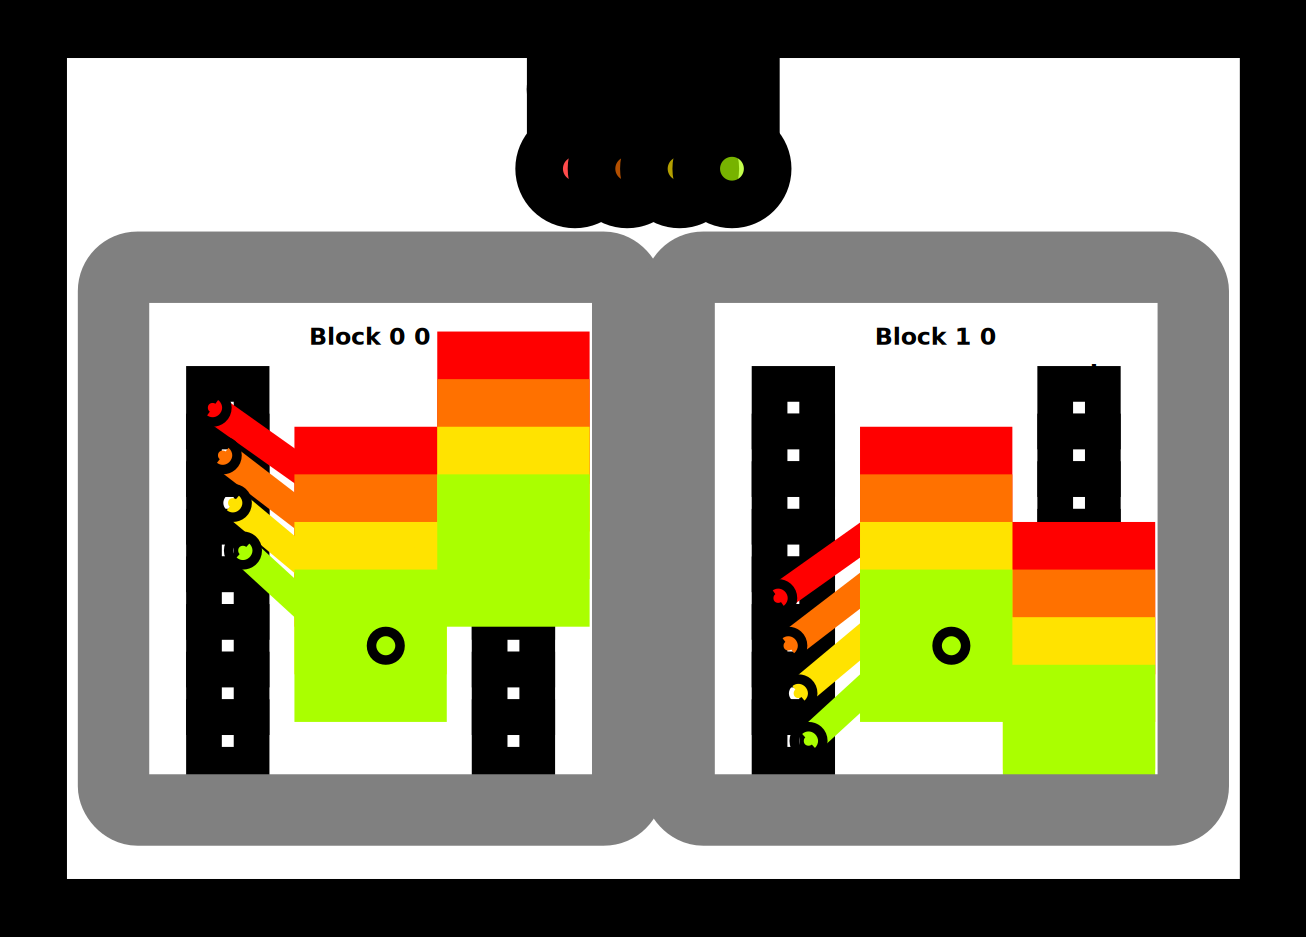

In [ ]:
TPB = 4
def shared_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        if i < size:
            shared[local_i] = a[i]
            cuda.syncthreads()

        # FILL ME IN (roughly 2 lines)
        if i < size:
            out[i] = shared[local_i] + 10
    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.ones(SIZE)
problem = CudaProblem(
    "Shared",
    shared_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(2, 1),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 9 - Pooling

Implement a kernel that sums together the last 3 position of `a` and stores it in `out`.
You have 1 thread per position. You only need 1 global read and 1 global write per thread.

*Tip: Remember to be careful about syncing.*

# Pooling
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             3 |             1 | 



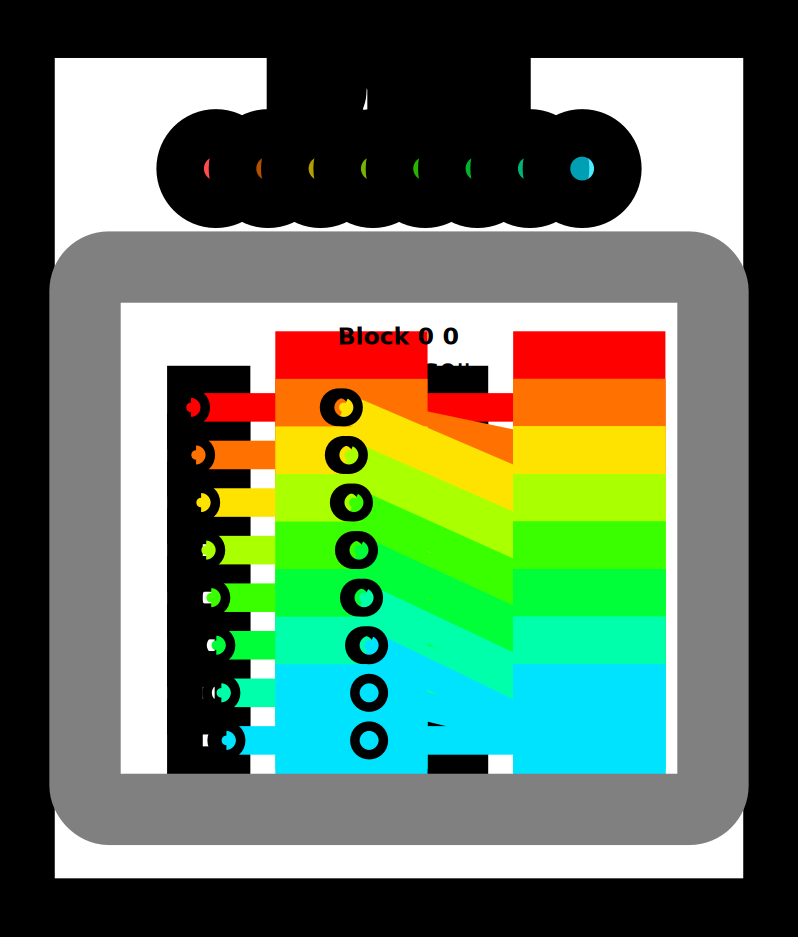

In [ ]:
def pool_spec(a):
    out = np.zeros(*a.shape)
    for i in range(a.shape[0]):
        out[i] = a[max(i - 2, 0) : i + 1].sum()
    return out


TPB = 8
def pool_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 8 lines)
        if i < size:
            shared[local_i] = a[i]
            cuda.syncthreads()
        acc = 0
        # assume we have 1 block?..
        for j in range(max(i - 2, 0), i + 1):
            acc += shared[j]
        if i < size:
            out[i] = acc
        cuda.syncthreads()
    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.arange(SIZE)
problem = CudaProblem(
    "Pooling",
    pool_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(1, 1),
    spec=pool_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 10 - Dot Product

Implement a kernel that computes the dot-product of `a` and `b` and stores it in `out`.
You have 1 thread per position. You only need 2 global reads and 1 global write per thread.

*Note: For this problem you don't need to worry about number of shared reads. We will
 handle that challenge later.*

# Dot
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             8 |             1 | 



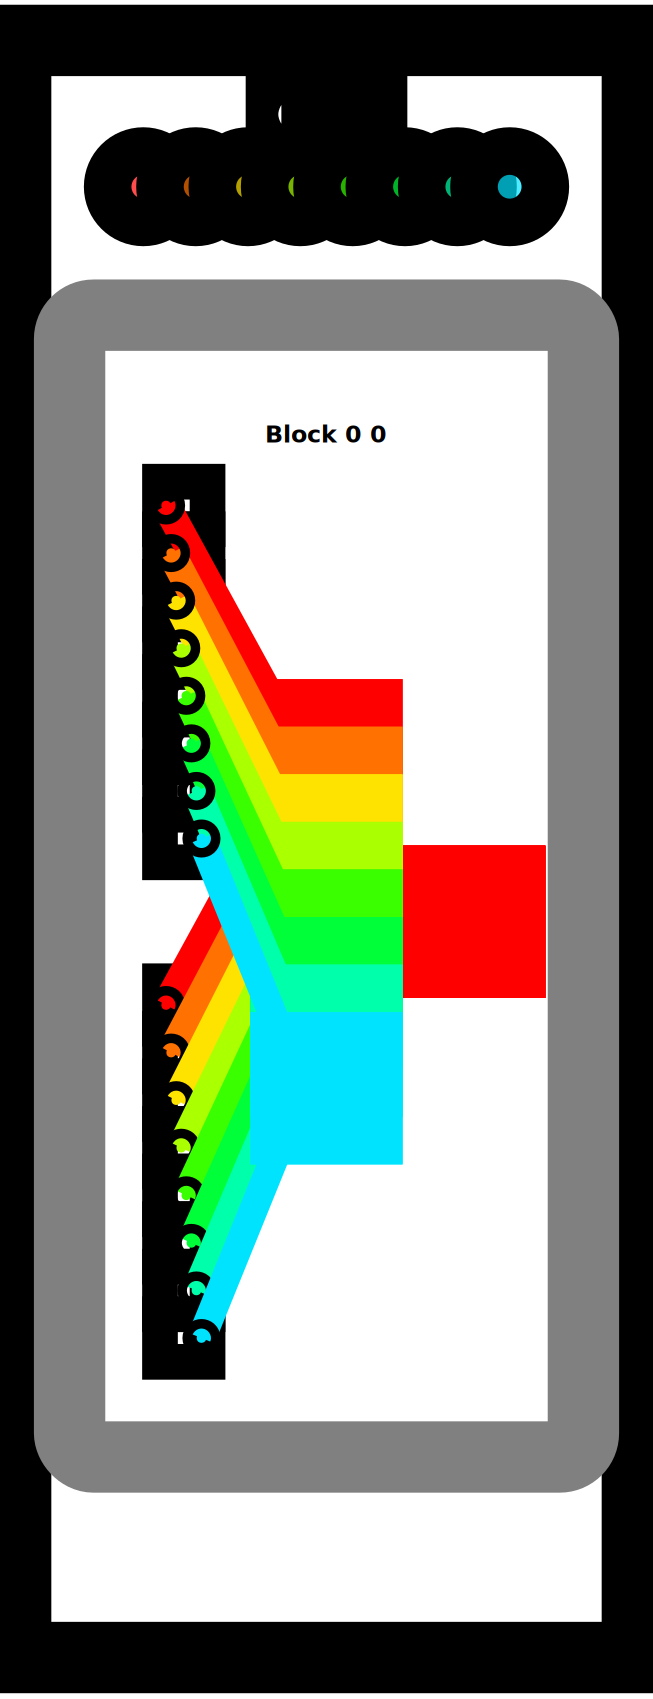

In [ ]:
def dot_spec(a, b):
    return a @ b

TPB = 8
def dot_test(cuda):
    def call(out, a, b, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 9 lines)
        if i < size:
            shared[local_i] = a[i] * b[i]
        cuda.syncthreads()
        # i don't get it. you can't sum over blocks...
        if local_i == 0:
            acc = 0
            for j in range(size):
                acc += shared[j]
            out[i] = acc
    return call


SIZE = 8
out = np.zeros(1)
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Dot",
    dot_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(SIZE, 1),
    blockspergrid=Coord(1, 1),
    spec=dot_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 11 - 1D Convolution

Implement a kernel that computes a 1D convolution between `a` and `b` and stores it in `out`.
You need to handle the general case. You only need 2 global reads and 1 global write per thread.

# 1D Conv (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             6 |             2 | 



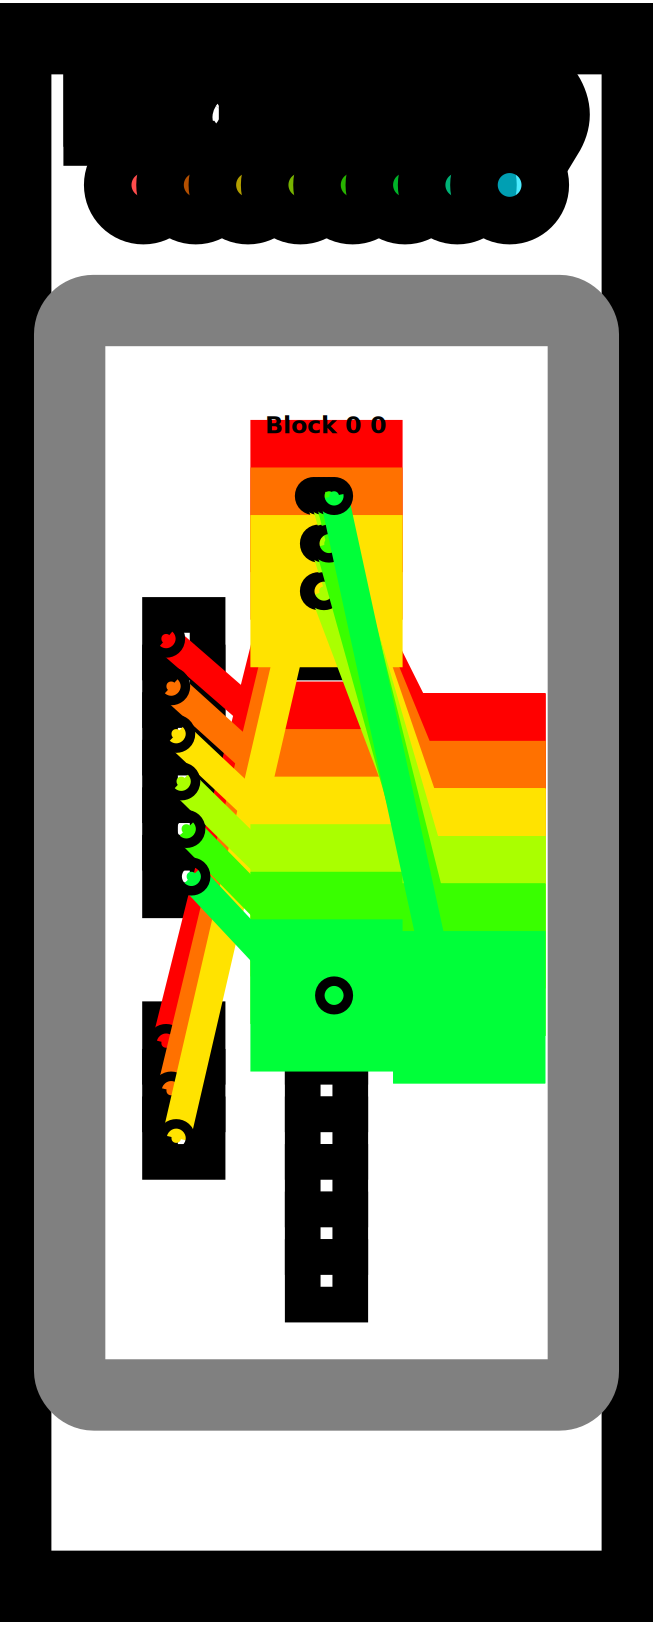

In [ ]:
def conv_spec(a, b):
    out = np.zeros(*a.shape)
    len = b.shape[0]
    for i in range(a.shape[0]):
        out[i] = sum([a[i + j] * b[j] for j in range(len) if i + j < a.shape[0]])
    return out


MAX_CONV = 4
TPB = 8
TPB_MAX_CONV = TPB + MAX_CONV
def conv_test(cuda):
    def call(out, a, b, a_size, b_size) -> None:
        shared_b = cuda.shared.array(MAX_CONV, numba.float32)
        shared_a = cuda.shared.array(TPB_MAX_CONV, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        # FILL ME IN (roughly 17 lines)
        if local_i < b_size:
            shared_b[local_i] = b[local_i]
        if i < a_size:
            shared_a[local_i] = a[i]
        if local_i >= MAX_CONV:
            if i - MAX_CONV + TPB < a_size:
                shared_a[local_i - MAX_CONV + TPB] = a[i - MAX_CONV + TPB]
        cuda.syncthreads()
        if i < a_size:
            acc = 0.0
            for j in range(b_size):
                if i + j < a_size:
                    acc += shared_a[local_i + j] * shared_b[j]
            out[i] = acc
    return call


# Test 1

SIZE = 6
CONV = 3
out = np.zeros(SIZE)
a = np.arange(SIZE)
b = np.arange(CONV)
problem = CudaProblem(
    "1D Conv (Simple)",
    conv_test,
    [a, b],
    out,
    [SIZE, CONV],
    Coord(1, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


# 1D Conv (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             8 |             2 | 



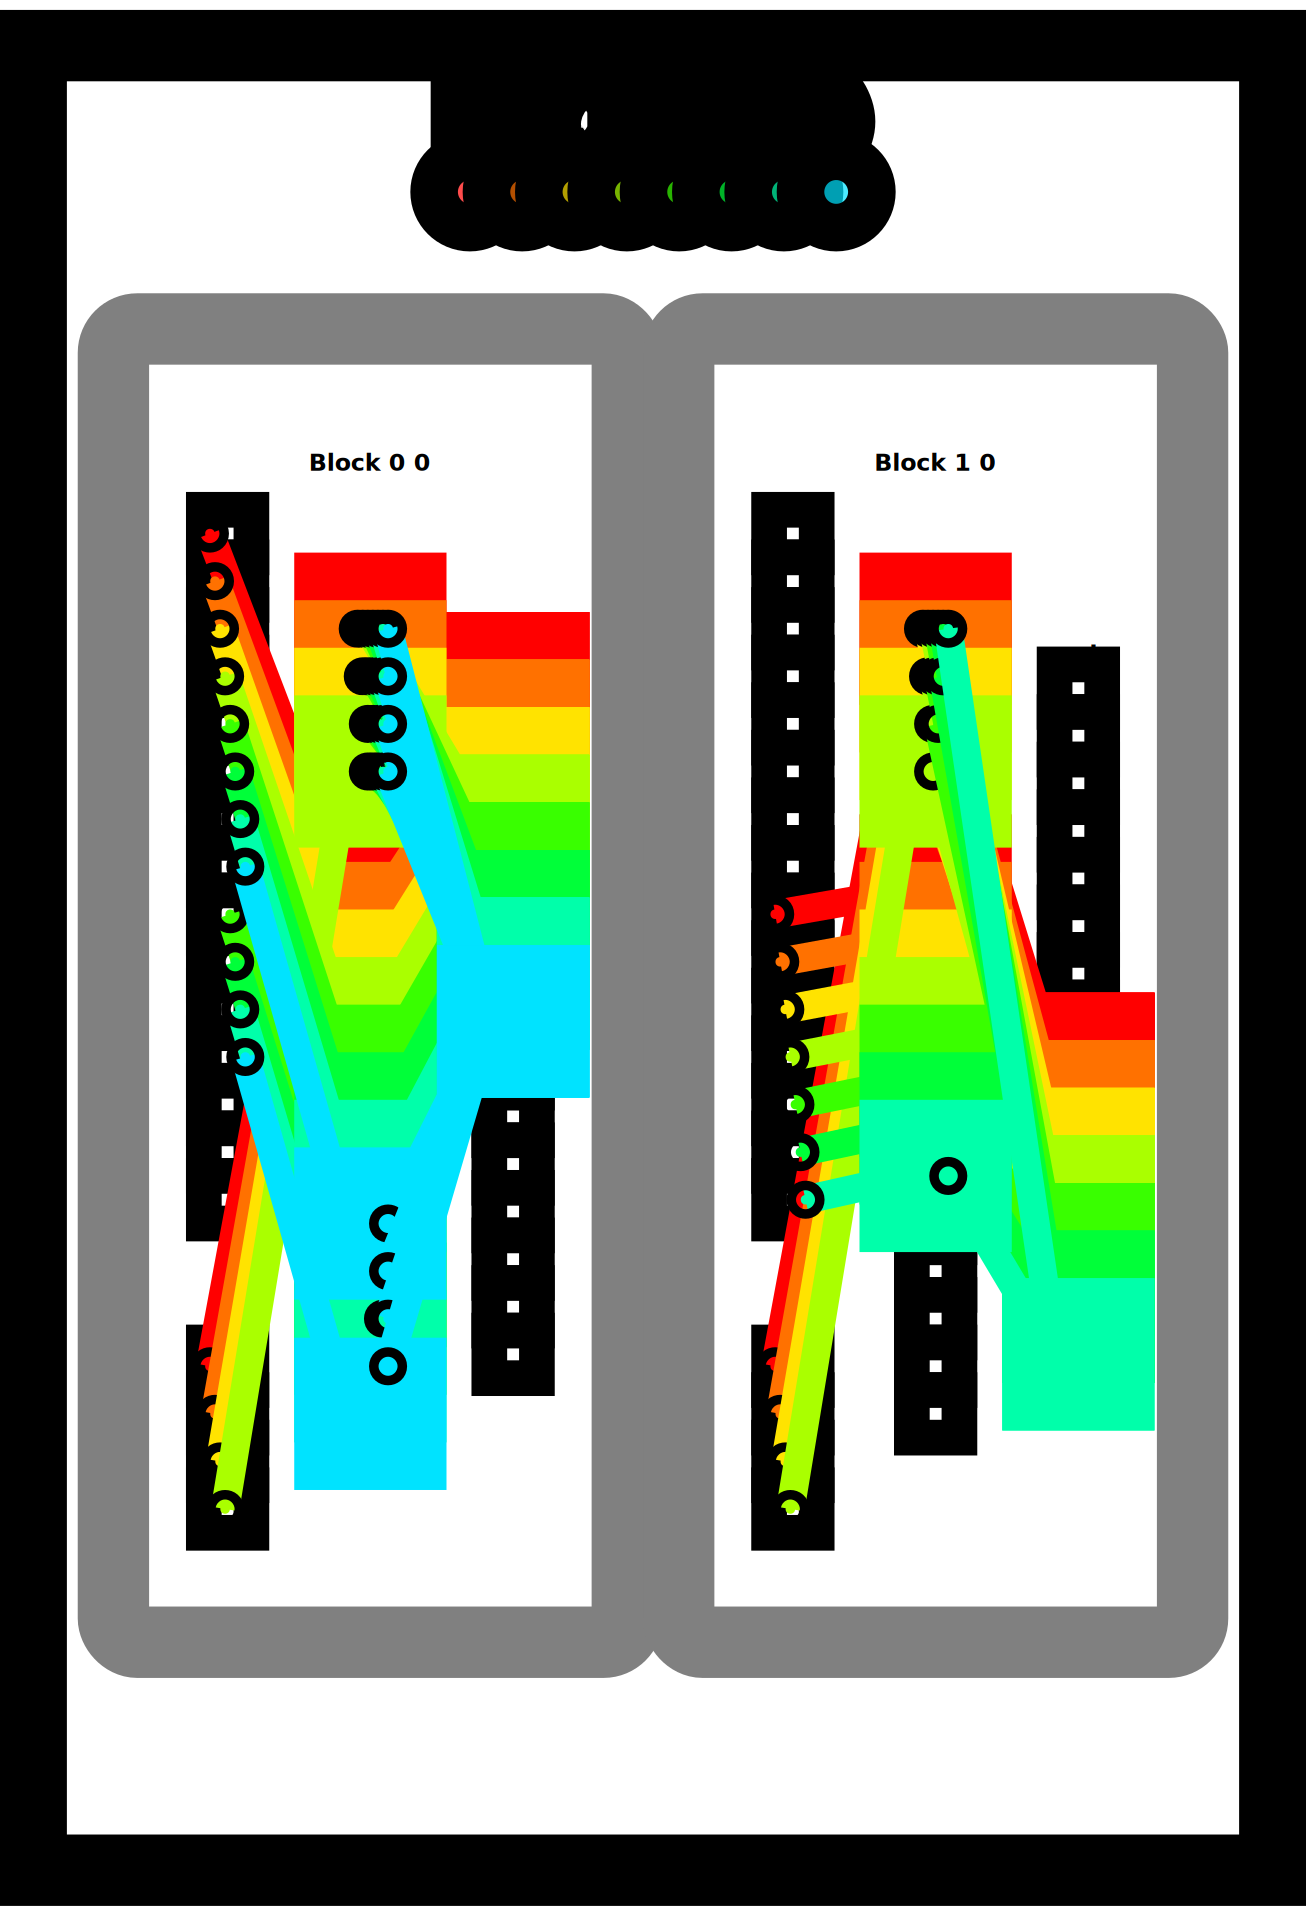

In [ ]:
#@title Test 2
out = np.zeros(15)
a = np.arange(15)
b = np.arange(4)
problem = CudaProblem(
    "1D Conv (Full)",
    conv_test,
    [a, b],
    out,
    [15, 4],
    Coord(2, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 12 - Prefix Sum

Implement a kernel that computes a sum over `a` and stores it in `out`.
If the size of `a` is greater than the block size, only store the sum of
each block.

We will do this using the [parallel prefix sum](https://en.wikipedia.org/wiki/Prefix_sum) algorithm in shared memory.
That is, each step of the algorithm should sum together half the remaining numbers.
Follow this diagram:

![](https://user-images.githubusercontent.com/35882/178757889-1c269623-93af-4a2e-a7e9-22cd55a42e38.png)

# Sum (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



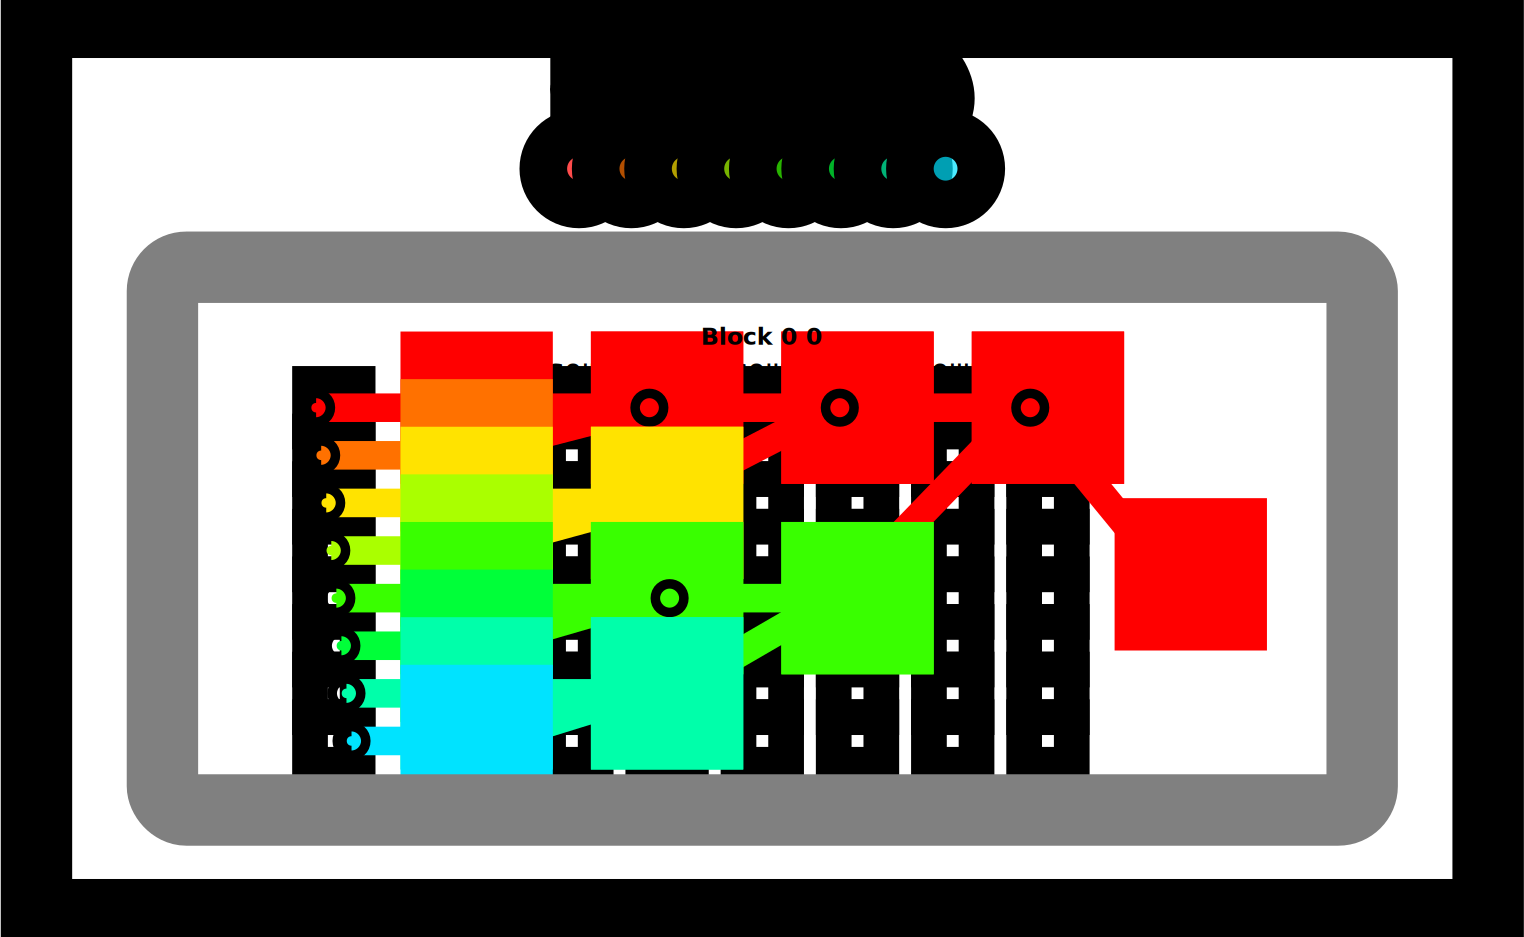

In [ ]:
from math import ceil


TPB = 8
def sum_spec(a):
    out = np.zeros((a.shape[0] + TPB - 1) // TPB)
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[j] = a[i : i + TPB].sum()
    return out


def sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 12 lines)
        if i < size:
            cache[local_i] = a[i]
        else:
            cache[local_i] = 0.0
        cuda.syncthreads()
        block = 2
        while block <= TPB:
            acc = 0.0
            if local_i % block == 0:
                acc = cache[local_i] + cache[local_i + block // 2]
            cuda.syncthreads()
            if local_i % block == 0:
                cache[local_i] = acc
            cuda.syncthreads()
            block *= 2
        if local_i == 0:
            out[cuda.blockIdx.x] = cache[0]
    return call


# Test 1

SIZE = 8
out = np.zeros(1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Simple)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord(1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


Test 2

# Sum (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



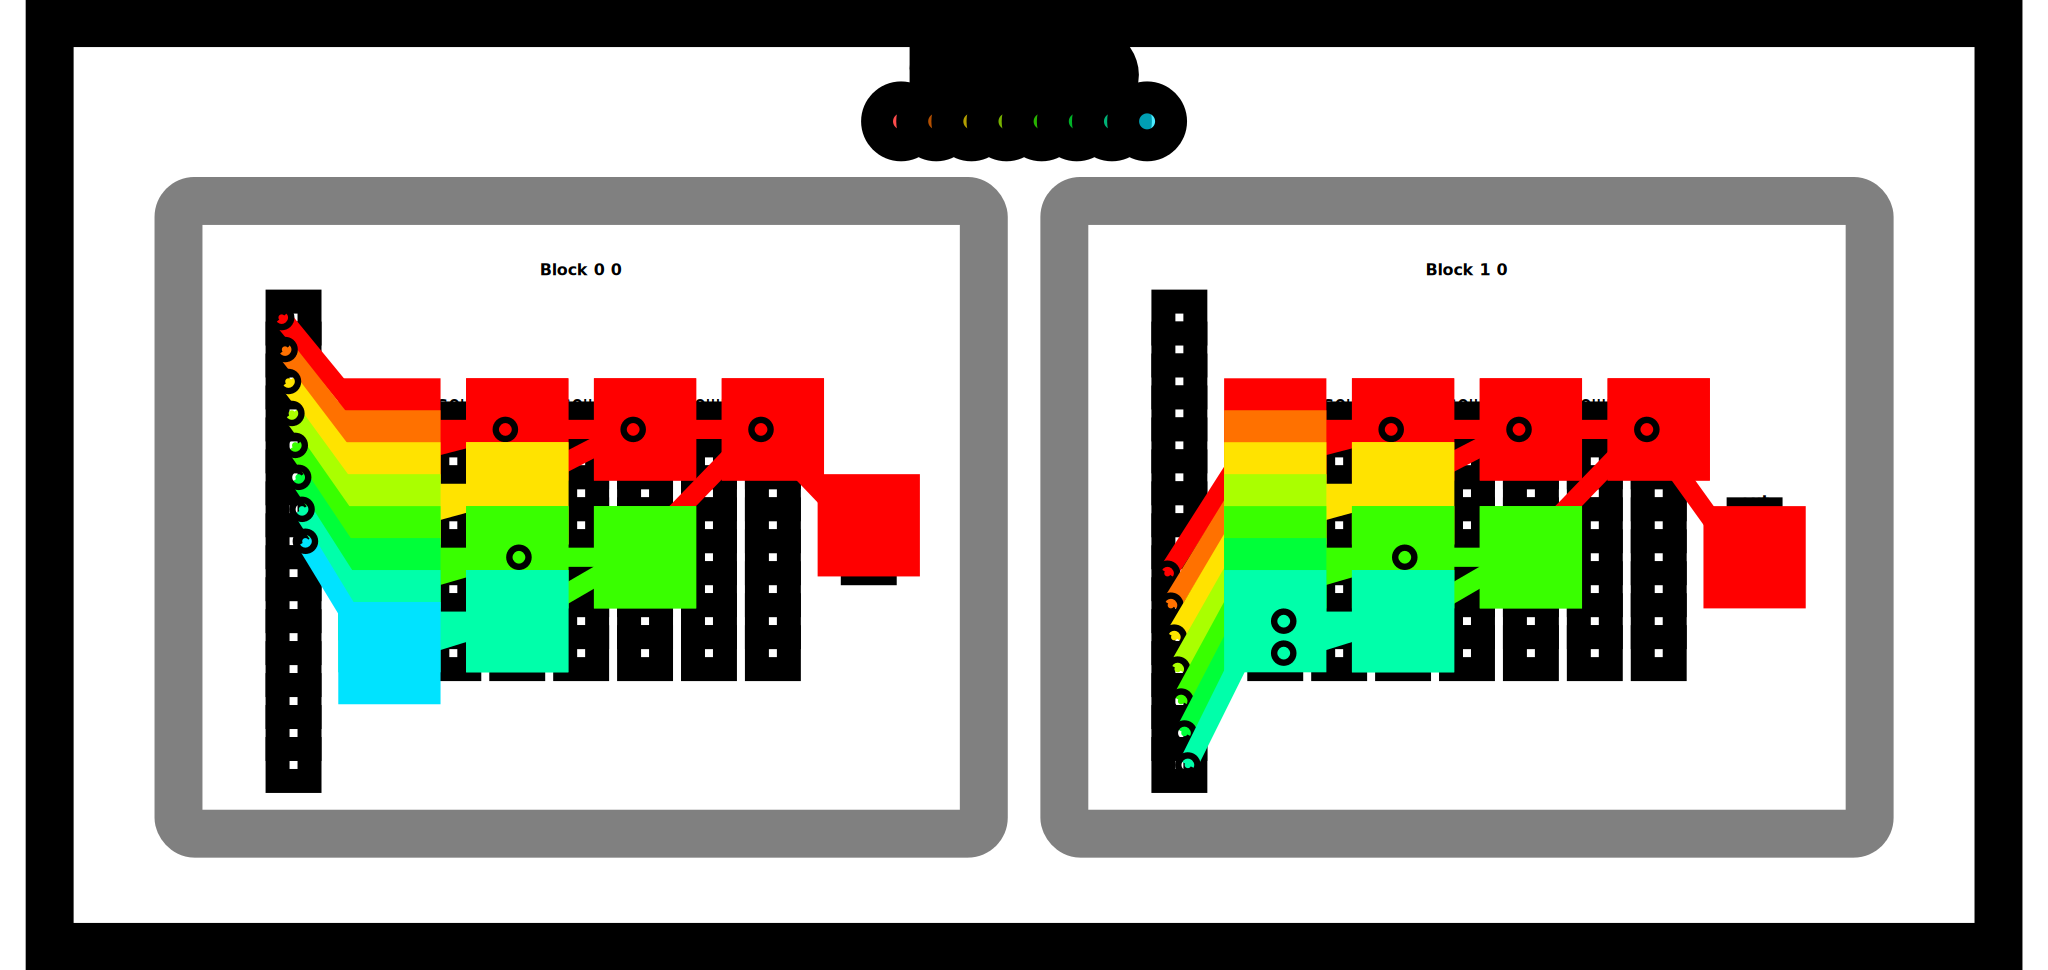

In [ ]:
SIZE = 15
out = np.zeros(2)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Full)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord(2, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 13 - Axis Sum

Implement a kernel that computes a sum over each column of `a` and stores it in `out`.

# Axis Sum
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             8 |             1 | 



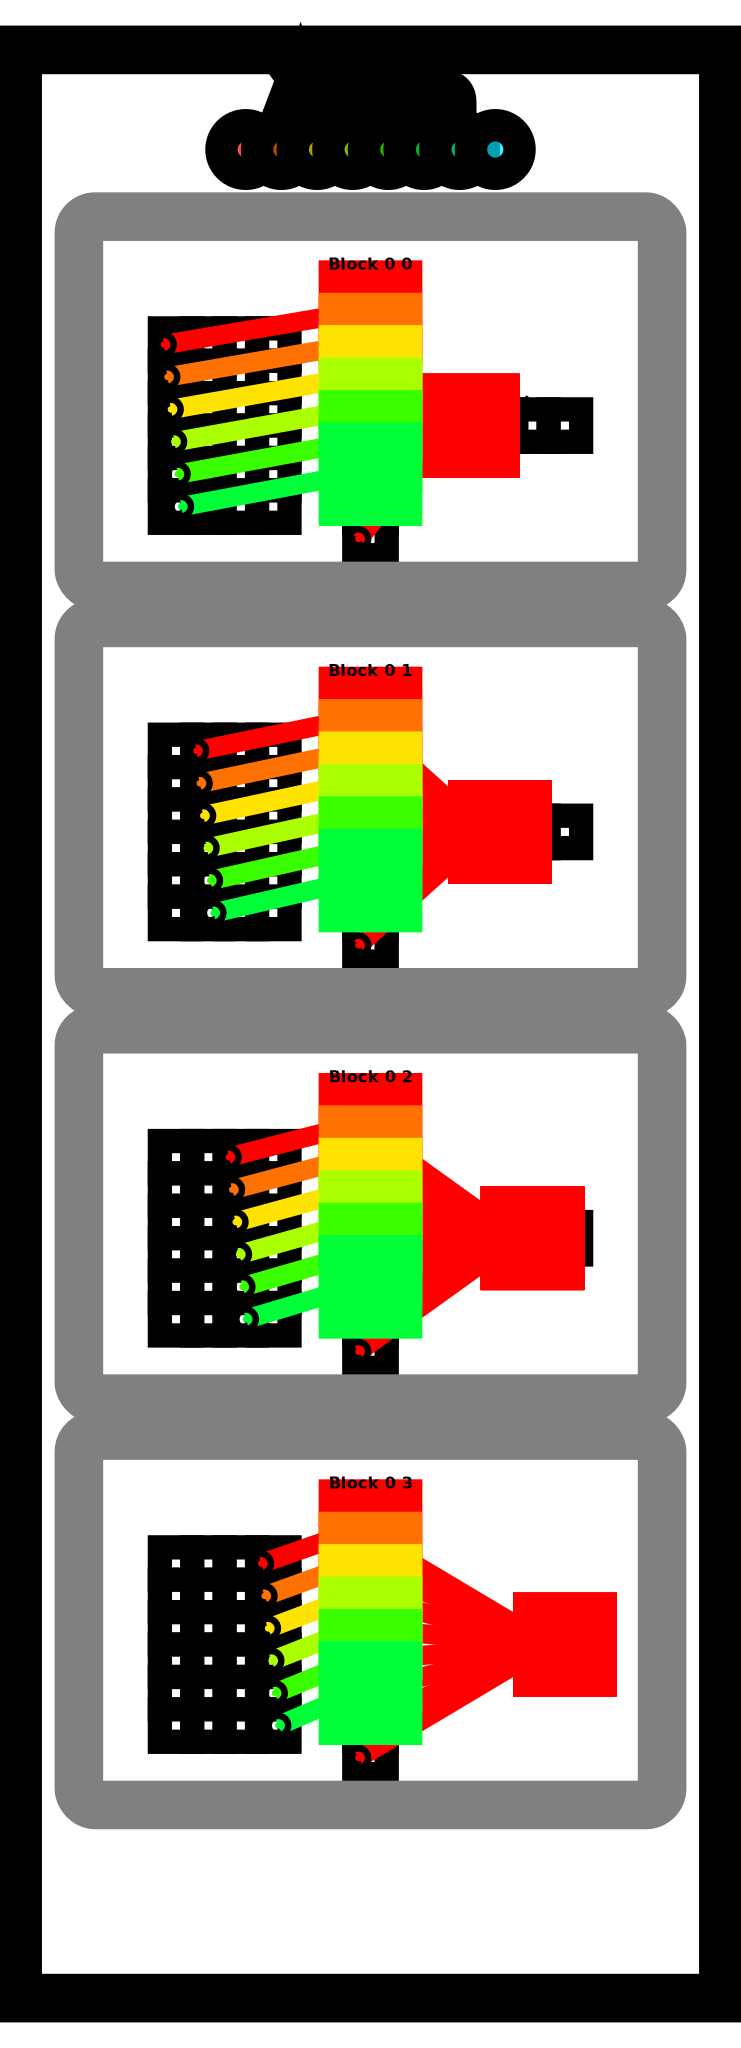

In [ ]:
TPB = 8
def sum_spec(a):
    out = np.zeros((a.shape[0], (a.shape[1] + TPB - 1) // TPB))
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[..., j] = a[..., i : i + TPB].sum(-1)
    return out


def axis_sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        batch = cuda.blockIdx.y
        # FILL ME IN (roughly 12 lines)
        if i < size:
            cache[local_i] = a[batch, i]
        else:
            cache[local_i] = 0.0
        cuda.syncthreads()
        if local_i == 0:
            acc = 0.0
            for j in range(TPB):
                acc += cache[j]
            out[batch, cuda.blockIdx.x] = acc
    return call


BATCH = 4
SIZE = 6
out = np.zeros((BATCH, 1))
inp = np.arange(BATCH * SIZE).reshape((BATCH, SIZE))
problem = CudaProblem(
    "Axis Sum",
    axis_sum_test,
    [inp],
    out,
    [SIZE],
    Coord(1, BATCH),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

Passed Tests!


## Puzzle 14 - Matrix Multiply!

Implement a kernel that multiplies square matrices `a` and `b` and
stores the result in `out`.

*Tip: The most efficient algorithm here will copy a block into
 shared memory before computing each of the individual row-column
 dot products. This is easy to do if the matrix fits in shared
 memory.  Do that case first. Then update your code to compute
 a partial dot-product and iteratively move the part you
 copied into shared memory.* You should be able to do the hard case
 in 6 global reads.

# Matmul (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             4 |             2 | 



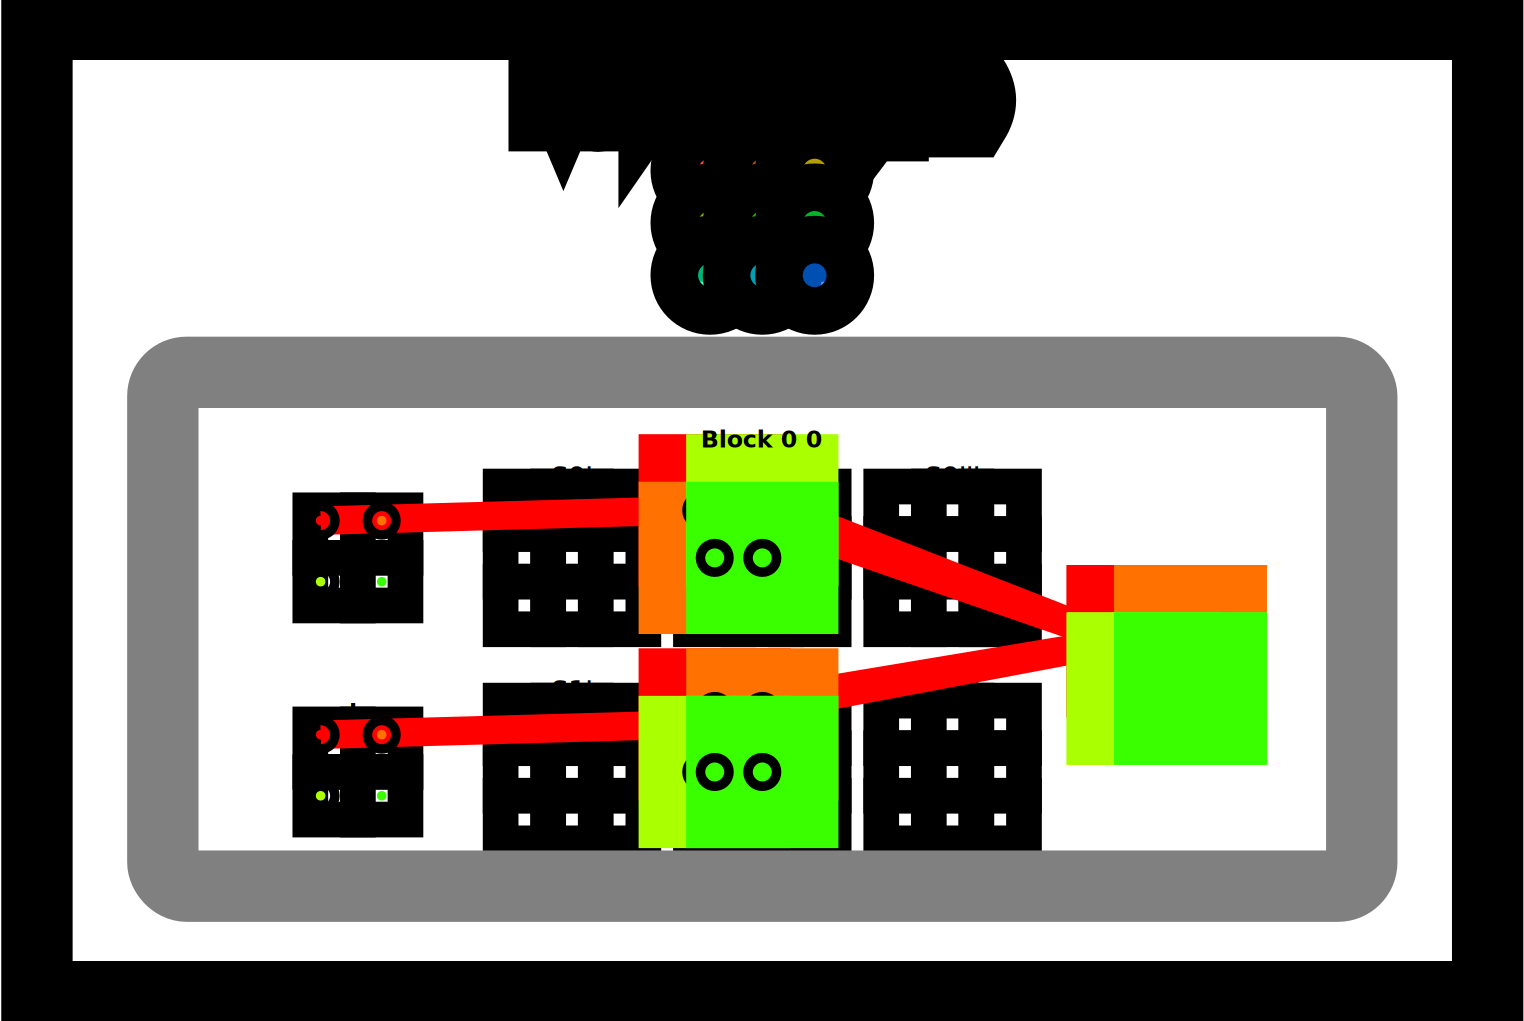

In [ ]:
# first 3 parts of https://siboehm.com/articles/22/CUDA-MMM, I think


def matmul_spec(a, b):
    return a @ b


TPB = 3
def mm_oneblock_test(cuda):
    def call(out, a, b, size: int) -> None:
        a_shared = cuda.shared.array((TPB, TPB), numba.float32)
        b_shared = cuda.shared.array((TPB, TPB), numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 14 lines)
        cuda.syncthreads()
        acc = 0.0
        for k_start in range(0, size, TPB):
            # we want to read from `a` with the corresponding row and a column slice with the other thread index (`local_j`)
            # we want the location in memory to have `k` as the first dimension so FMAs can be coalesced
            if i < size and k_start + local_j < size:
                a_shared[local_j, local_i] = a[i, k_start + local_j]
            # same here
            # we want to read from `a` with the corresponding column and a row slice with the other thread index (`local_i`)
            # we want the location in memory to have `k` as the first dimension so FMAs can be coalesced
            if k_start + local_i < size and j < size:
                b_shared[local_i, local_j] = b[k_start + local_i, j]

            cuda.syncthreads()
            for k in range(min(TPB, size - k_start)):
                # we index both arrays with `k` and then index with the corresponding local row
                acc += a_shared[k, local_i] * b_shared[k, local_j]
            cuda.syncthreads()
        if i < size and j < size:
            out[i, j] = acc
    return call

# Test 1

SIZE = 2
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Simple)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(1, 1),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.show(sparse=True)

In [ ]:
problem.check()

Passed Tests!


Test 2

# Matmul (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             6 |             1 |            16 |             6 | 



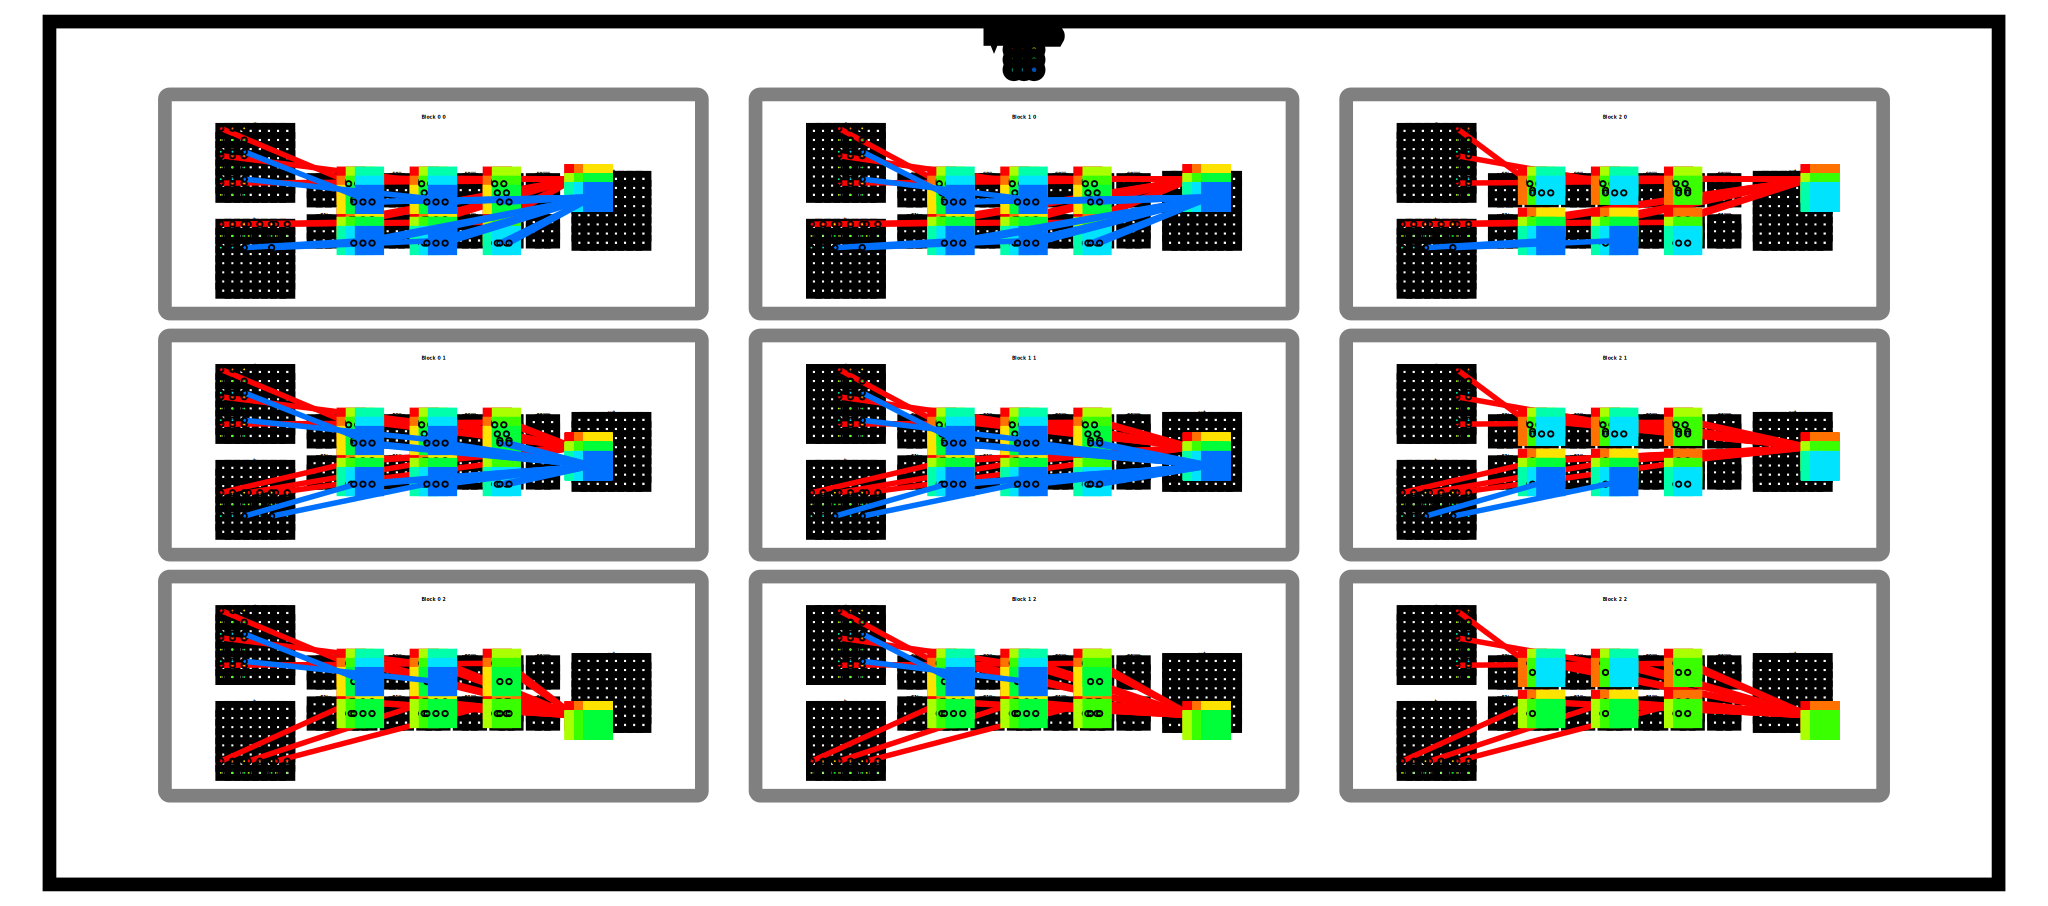

In [ ]:
SIZE = 8
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Full)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(3, 3),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.show(sparse=True)

In [ ]:
problem.check()

Passed Tests!
